In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.14.0

Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 5.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt


In [2]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 52.7 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from glob import glob
from tqdm import tqdm
import warnings,time,cv2,pickle,random
from keras.utils import img_to_array, load_img
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sklearn.model_selection import StratifiedShuffleSplit
import hdbscan
import matplotlib.colors as mcolors
warnings.filterwarnings("ignore")

2025-05-07 11:03:53.951034: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 11:03:53.951099: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 11:03:53.951159: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
gen = tf.keras.models.load_model('/kaggle/input/rgb2ir_cgan_53k/tensorflow2/default/1/generator_full_2_dgx.keras')
disc = tf.keras.models.load_model('/kaggle/input/rgb2ir-cgan-discriminator/tensorflow2/default/1/discriminator_full_2_dgx.keras')

In [5]:
rgb_image_path = '/kaggle/input/flame2-rgb-ir-frame-pairs/254p Frame Pairs/254p RGB Images'
ir_image_path = '/kaggle/input/flame2-rgb-ir-frame-pairs/254p Frame Pairs/254p Thermal Images'

In [19]:
def convertRGB2IR(rgb,ir,onlyeval=False):
    predicted = gen.predict(tf.expand_dims(rgb, axis=0),verbose=0)[0]
    if not onlyeval:
        plt.figure(figsize=(10,8))
        plt.subplot(1,3,1)
        plt.imshow(rgb)
        plt.title("RGB Image")
        plt.axis('off')
    
        plt.subplot(1,3,2)
        plt.imshow(ir)
        plt.title("True Thermal Image")
        plt.axis('off')
    
        plt.subplot(1,3,3)
        plt.imshow(predicted)
        plt.title("Generated Thermal Image")
        plt.axis('off')
    
        plt.show()
    mse = mean_squared_error(ir, predicted)
    psnr = peak_signal_noise_ratio(ir, predicted, data_range=predicted.max() - predicted.min())
    ssim = structural_similarity(ir, predicted, win_size=101, channel_axis=-1,data_range=predicted.max() - predicted.min())
    mae = np.mean(np.abs(ir-predicted))
    
    if not onlyeval:
        print(f"MSE: {mse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"PSNR: {psnr:.2f} dB")
        print(f"SSIM: {ssim:.4f}\n")
    return mse,psnr,ssim,mae,predicted

In [7]:
def load_and_preprocess_image(rgb_path, ir_path):
    rgb_image = tf.io.read_file(rgb_path)
    ir_image = tf.io.read_file(ir_path)
    
    rgb_image = tf.image.decode_jpeg(rgb_image, channels=3)
    ir_image = tf.image.decode_jpeg(ir_image, channels=3)
    
    rgb_image = tf.image.resize(rgb_image, (256,256), method='bicubic')
    ir_image = tf.image.resize(ir_image, (256,256), method='bicubic')
    
    rgb_image = rgb_image / 255.0
    ir_image = ir_image / 255.0
    return rgb_image, ir_image

In [46]:
def compute_fire_severity(segmented_image,coldict):
    labs = segmented_image.flatten()
    labs = np.vectorize(coldict.get)(labs)
    pxden = pd.Series(labs).value_counts()/len(labs)
    fire_sev = (pxden['red']+pxden['orange'])*100
    print(f"% Area covered by fire = {fire_sev:.3f}%")
    return fire_sev
    
def segment_image(image,min_cluster_size=100,verbose=False,plotincorrect=False):
  pixels = image.reshape(-1, 3)
  c = 0
  while c<=5:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusterer.fit(pixels)
    labels = clusterer.labels_
    segmented_image = labels.reshape(image.shape[:2])
    cluster_labels = np.unique(segmented_image.flatten())
    print(cluster_labels,np.unique(labels))
    if len(cluster_labels)>3:
      if verbose:
        print(f"Got {len(cluster_labels)} clusters from HDBSCAN, increasing min_cluster_size by 20")
        if plotincorrect:
            plt.imshow(segmented_image)
            plt.show()
            print()
      c+=1
      min_cluster_size += 20
      continue
    elif len(cluster_labels)<3:
      if verbose:
        print(f"Got {len(cluster_labels)} clusters from HDBSCAN, decreasing min_cluster_size by 10")
        if plotincorrect:
            plt.imshow(segmented_image)
            plt.show()
            print()
      c+=1
      min_cluster_size -= 10
      continue
    else:
      if verbose:
        print(f"Got perfect {len(cluster_labels)} clusters from HDBSCAN!")
      break
  if c>5:
    print("Could not segment the image properly")
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  avg_values = {}
  for label in cluster_labels:
    cluster_pixels = gray[segmented_image == label]
    avg_values[label] = cluster_pixels.mean()
  avg_values = {k: v for k, v in sorted(avg_values.items(), key=lambda item: item[1])}
  coldict = dict(zip(list(avg_values.keys()),['blue','red','orange']))
  colored_image = np.zeros((256,256, 3))
  for label, color in coldict.items():
    rgb = np.array(mcolors.to_rgb(color))  # Normalize to 0-1
    colored_image[segmented_image == label] = rgb
      
  fire_sev = compute_fire_severity(segmented_image,coldict)
  return segmented_image,colored_image,coldict,fire_sev

def disp_images(orig, segm, fire_sev):
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)
  plt.imshow(orig)
  plt.title("Generated Thermal Image",fontsize=30)
  plt.axis('off')
  plt.subplot(1, 2, 2)
  plt.imshow(segm)
  plt.title(f"Segmented Image\nFire Severity = {fire_sev:.3f}%",fontsize=30)
  plt.axis('off')
  plt.subplots_adjust(wspace=0.4)
  #plt.tight_layout()
  plt.show()

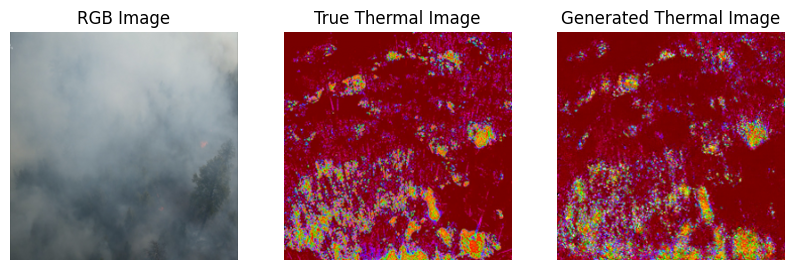

MSE: 0.0338
MAE: 0.1090
PSNR: 17.76 dB
SSIM: 0.3922



In [21]:
rfid = 30096
srgb_path = f'{rgb_image_path}/254p RGB Frame ({rfid}).jpg'
sir_path = f'{ir_image_path}/254p Thermal Frame ({rfid}).jpg'
samp_rgb,samp_ir = load_and_preprocess_image(srgb_path,sir_path)
samp_rgb,samp_ir = np.array(samp_rgb),np.array(samp_ir)
mse,psnr,ssim,mae,predicted = convertRGB2IR(samp_rgb,samp_ir)

[-1] [-1]
Got 1 clusters from HDBSCAN, decreasing min_cluster_size by 10


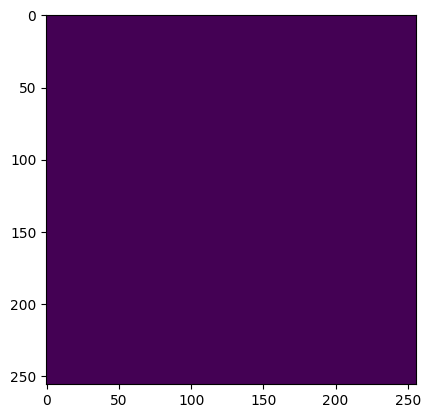


[-1] [-1]
Got 1 clusters from HDBSCAN, decreasing min_cluster_size by 10


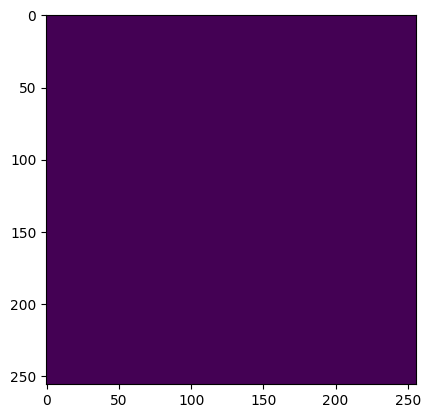


[-1] [-1]
Got 1 clusters from HDBSCAN, decreasing min_cluster_size by 10


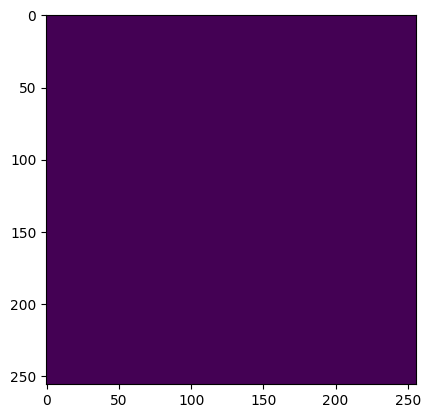


[-1  0  1] [-1  0  1]
Got perfect 3 clusters from HDBSCAN!
% Area covered by fire = 15.977%


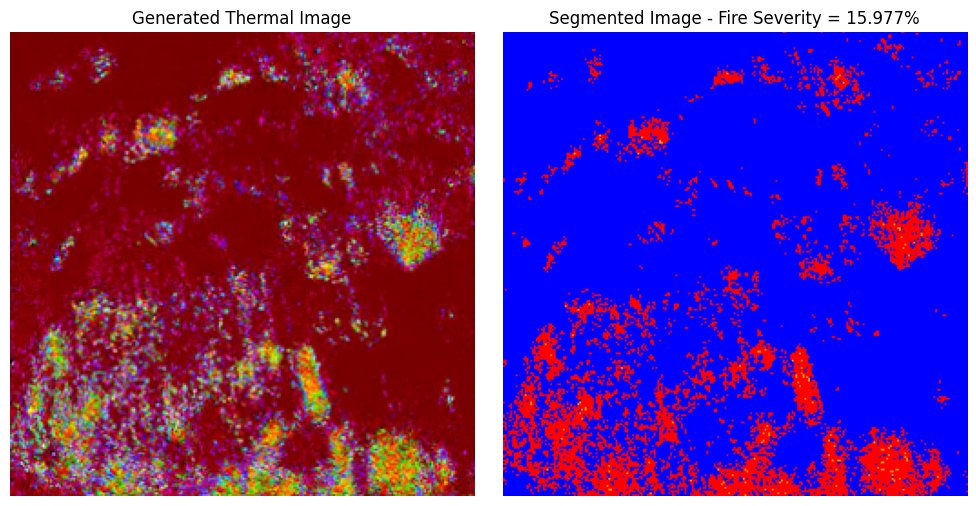

In [22]:
segmented_image,colored_image,coldict,fire_sev = segment_image(predicted,min_cluster_size=100,verbose=True,plotincorrect=True)
disp_images(predicted, colored_image,fire_sev)

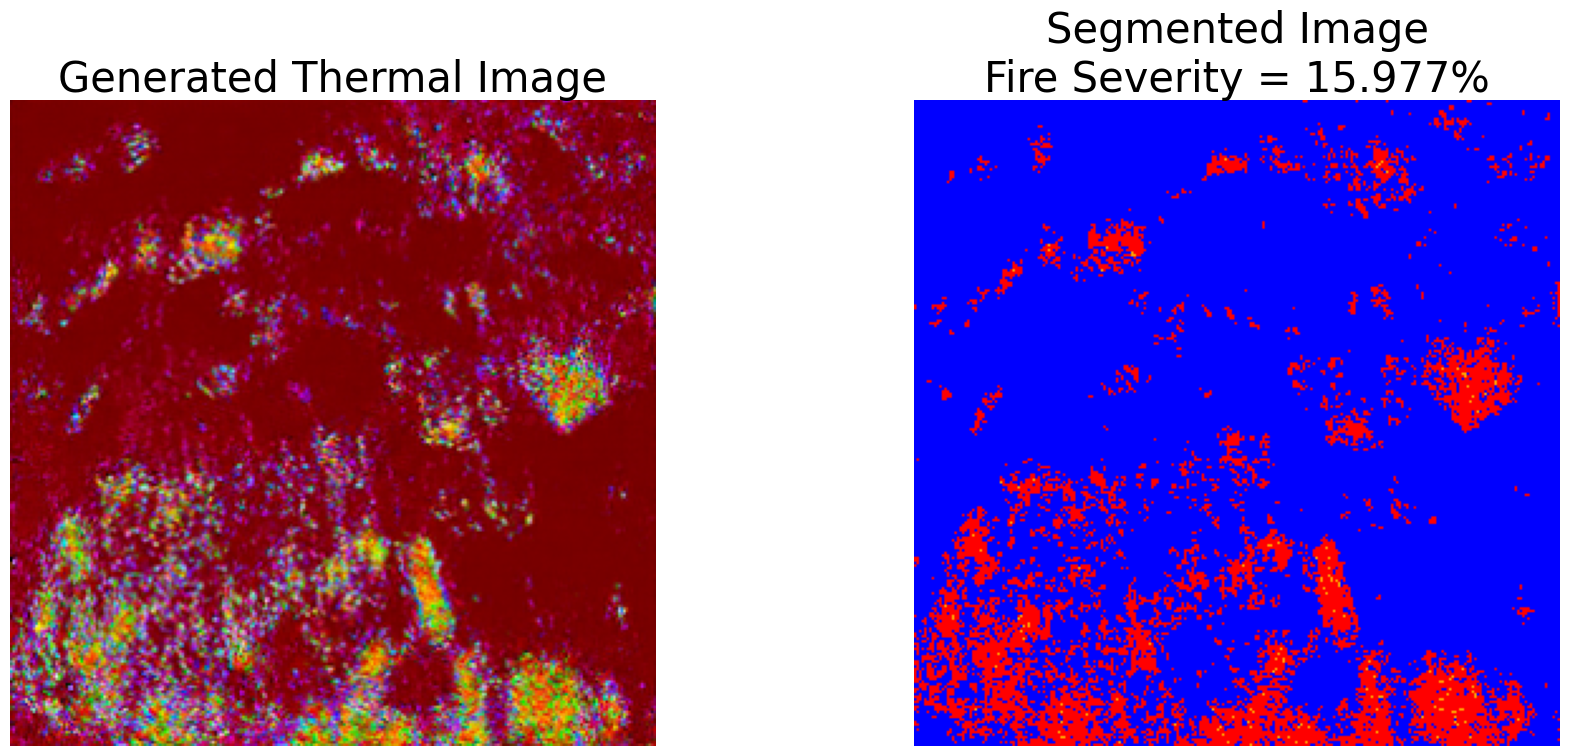

In [47]:
disp_images(predicted, colored_image,fire_sev)

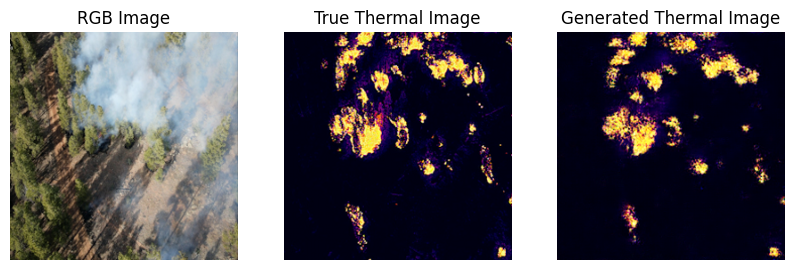

MSE: 0.0152
MAE: 0.0467
PSNR: 21.61 dB
SSIM: 0.7190



In [55]:
rfid = np.random.randint(13700,53451)
srgb_path = f'{rgb_image_path}/254p RGB Frame ({rfid}).jpg'
sir_path = f'{ir_image_path}/254p Thermal Frame ({rfid}).jpg'
samp_rgb,samp_ir = load_and_preprocess_image(srgb_path,sir_path)
samp_rgb,samp_ir = np.array(samp_rgb),np.array(samp_ir)
mse,psnr,ssim,mae,predicted = convertRGB2IR(samp_rgb,samp_ir)

[-1  0  1] [-1  0  1]
Got perfect 3 clusters from HDBSCAN!
% Area covered by fire = 9.277%


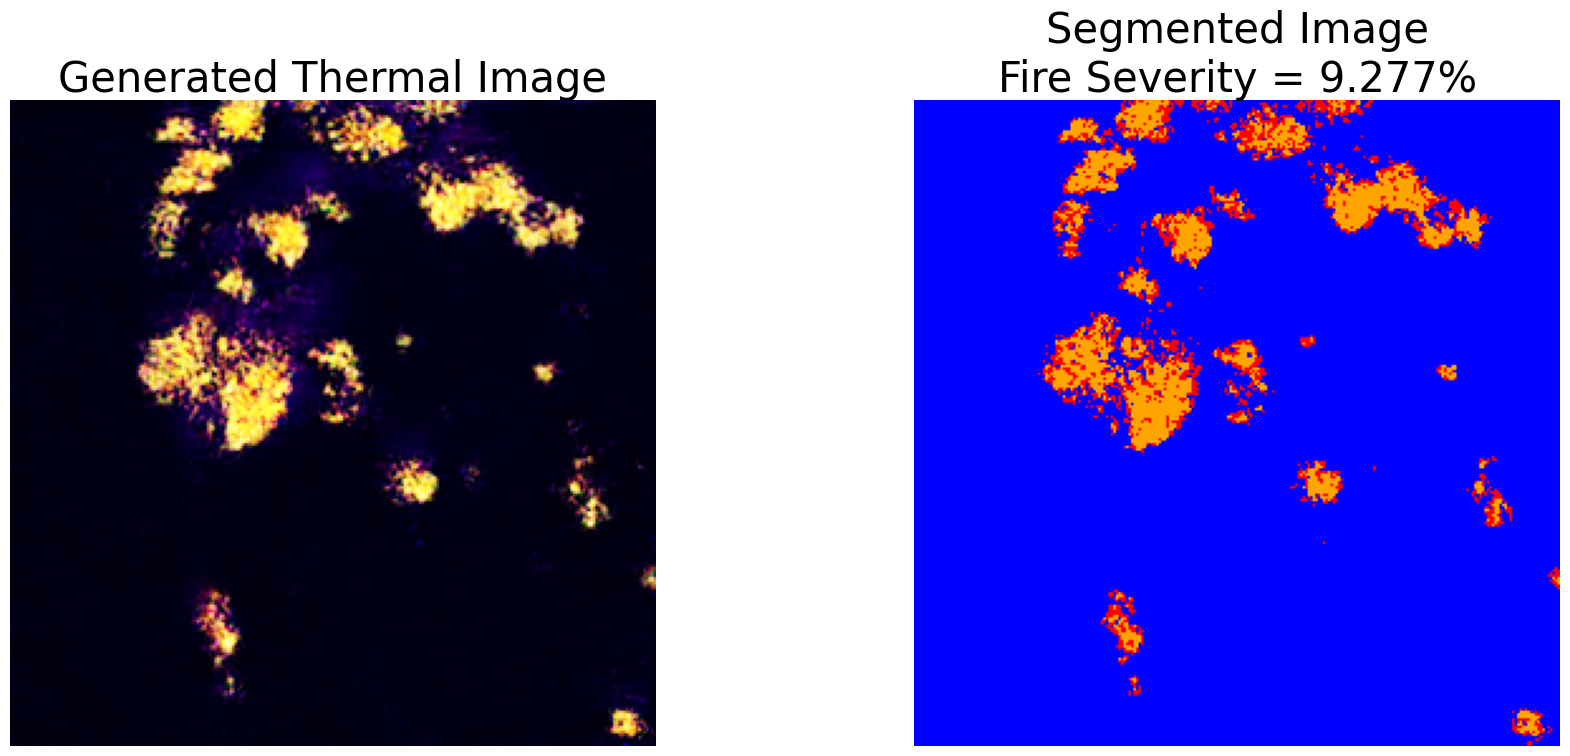

In [56]:
segmented_image,colored_image,coldict,fire_sev = segment_image(predicted,min_cluster_size=100,verbose=True,plotincorrect=True)
disp_images(predicted, colored_image,fire_sev)

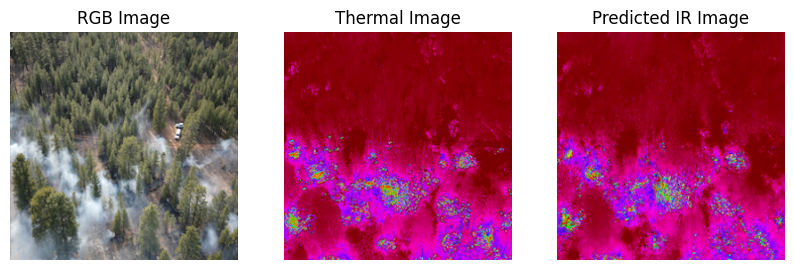

MSE: 0.0148
MAE: 0.0621
PSNR: 20.94 dB
SSIM: 0.6678



In [12]:
rfid = np.random.randint(13700,53451)
srgb_path = f'{rgb_image_path}/254p RGB Frame ({rfid}).jpg'
sir_path = f'{ir_image_path}/254p Thermal Frame ({rfid}).jpg'
samp_rgb,samp_ir = load_and_preprocess_image(srgb_path,sir_path)
samp_rgb,samp_ir = np.array(samp_rgb),np.array(samp_ir)
mse,psnr,ssim,mae,predicted = convertRGB2IR(samp_rgb,samp_ir)

[-1  0  1  2  3] [-1  0  1  2  3]
Got 5 clusters from HDBSCAN, increasing min_cluster_size by 20


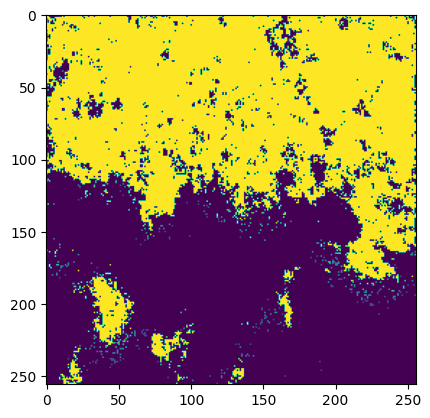


[-1  0  1] [-1  0  1]
Got perfect 3 clusters from HDBSCAN!
% Area covered by fire = 48.715%


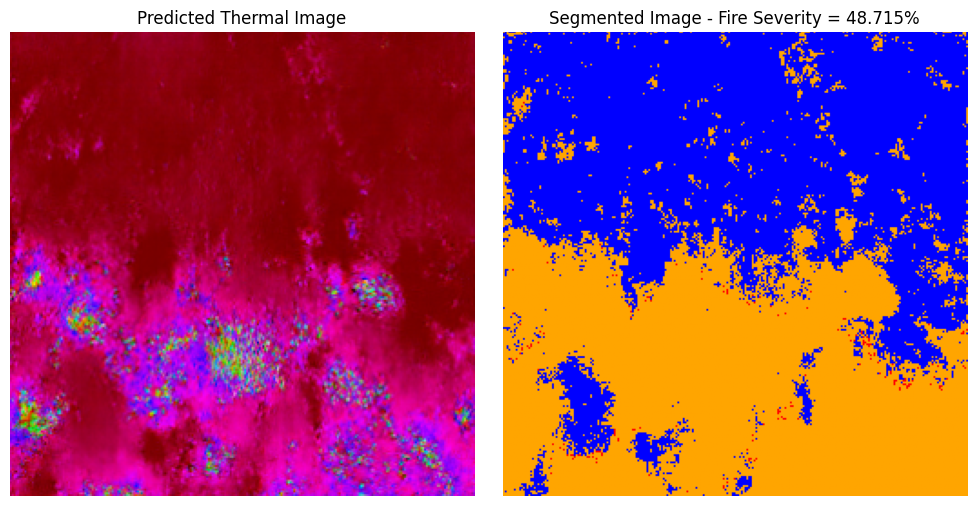

In [22]:
segmented_image,colored_image,coldict,fire_sev = segment_image(predicted,min_cluster_size=100,verbose=True,plotincorrect=True)
disp_images(predicted, colored_image,fire_sev)

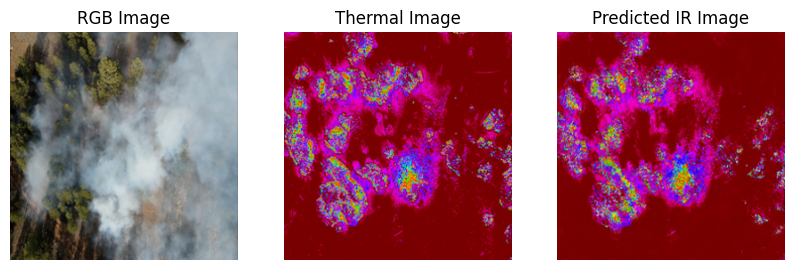

MSE: 0.0237
MAE: 0.0795
PSNR: 19.48 dB
SSIM: 0.5999



In [25]:
rfid = np.random.randint(13700,53451)
srgb_path = f'{rgb_image_path}/254p RGB Frame ({rfid}).jpg'
sir_path = f'{ir_image_path}/254p Thermal Frame ({rfid}).jpg'
samp_rgb,samp_ir = load_and_preprocess_image(srgb_path,sir_path)
samp_rgb,samp_ir = np.array(samp_rgb),np.array(samp_ir)
mse,psnr,ssim,mae,predicted = convertRGB2IR(samp_rgb,samp_ir)

[-1  0  1] [-1  0  1]
Got perfect 3 clusters from HDBSCAN!
% Area covered by fire = 35.237%


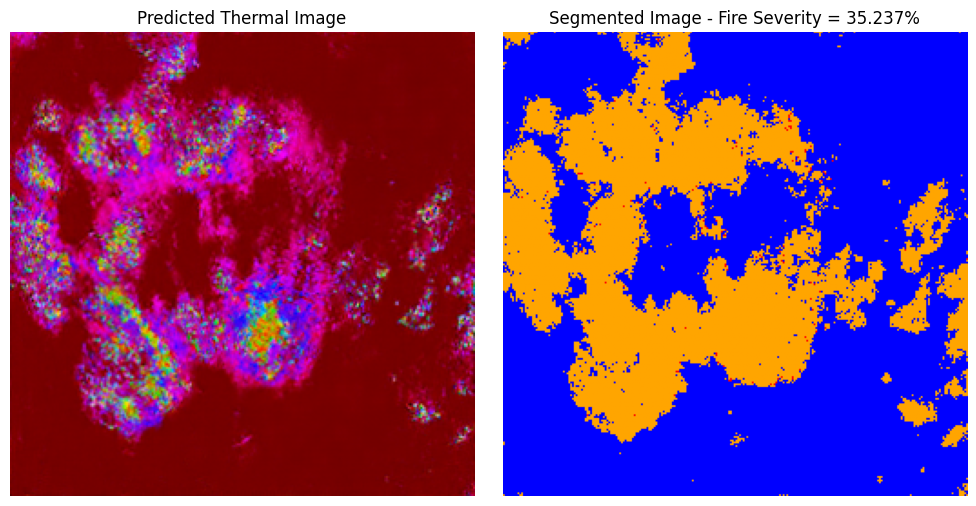

In [26]:
segmented_image,colored_image,coldict,fire_sev = segment_image(predicted,min_cluster_size=100,verbose=True,plotincorrect=True)
disp_images(predicted, colored_image,fire_sev)

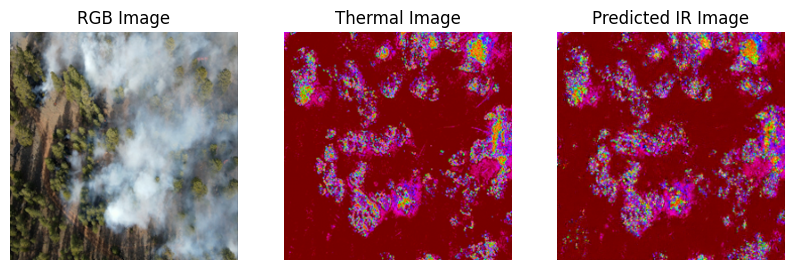

MSE: 0.0205
MAE: 0.0763
PSNR: 20.50 dB
SSIM: 0.6411



In [27]:
rfid = np.random.randint(13700,53451)
srgb_path = f'{rgb_image_path}/254p RGB Frame ({rfid}).jpg'
sir_path = f'{ir_image_path}/254p Thermal Frame ({rfid}).jpg'
samp_rgb,samp_ir = load_and_preprocess_image(srgb_path,sir_path)
samp_rgb,samp_ir = np.array(samp_rgb),np.array(samp_ir)
mse,psnr,ssim,mae,predicted = convertRGB2IR(samp_rgb,samp_ir)